In [43]:
import pandas as pd
from datetime import timedelta, datetime 
import matplotlib.pyplot as plt
import os
import xarray as xr
lat_galeao = -22.8089
lon_galeao = -43.2436

extent = [-74.0, -34.1, -34.8, 5.5] # Min lon, Min lat, Max lon, Max lat

min_lon = extent[0]
min_lat = extent[1]
max_lon = extent[2]
max_lat = extent[3]

In [60]:
path = "/Users/viniciusgoncalves/CEFET/atmoseer/data/goes16/dsif/"
dir_list = os.listdir(path)
goes16_data = pd.DataFrame(columns=['time', 'goes16_cape', 'goes16_ki', 'goes16_si', 'goes16_li', 'goes16_tt'])

times_of_day = [ '0000', '1200']
begin = '20200101'
end = '20200131'

begin = begin + times_of_day[0]
end  = end + times_of_day[1]


begin_date = datetime.strptime(begin, '%Y%m%d%H%M')
end_date = datetime.strptime(end, '%Y%m%d%H%M')

for file in dir_list:
    current_date = datetime.strptime(file[0:12], '%Y%m%d%H%M')
    if begin_date <= current_date <= end_date:
        #if current_date.hour in (0,12) and current_date.minute == 0:
        data = pd.read_pickle(path + file)
        cape = pd.DataFrame(data["CAPE"])
        ki = pd.DataFrame(data["KI"])
        si = pd.DataFrame(data["SI"])
        li = pd.DataFrame(data["LI"])
        tt = pd.DataFrame(data["TT"])
        num_points_x, num_points_y =  cape.shape 


        axis_y = (min_lat - max_lat) / num_points_y
        axis_x = (max_lon - min_lon) / num_points_x

        y = int((lat_galeao - max_lat) / axis_y)
        x = int((lon_galeao - min_lon) / axis_x)
        
        
        goes16_data.loc[len(goes16_data.index)] =  [current_date,  cape.iat[x,y], ki.iat[x,y], si.iat[x,y], li.iat[x,y], tt.iat[x,y]]
goes16_data = goes16_data.sort_values('time')                  

In [61]:
print(goes16_data.head())

                    time goes16_cape  goes16_ki goes16_si goes16_li  goes16_tt
4352 2020-01-01 00:00:00     9.00351  14.481506  8.288994  0.437214  36.915024
3277 2020-01-01 00:10:00    8.698306  14.408257  8.324245  0.450185  36.885162
830  2020-01-01 00:20:00         0.0  13.803955  8.506378  0.701979  36.551941
271  2020-01-01 00:30:00         0.0  13.520111  8.595573    0.7531  36.474922
1651 2020-01-01 00:40:00         0.0  13.236275  8.677292  0.788961  36.393188


In [68]:
goes16_data_agg = goes16_data.resample('2h', on='time').mean()
goes16_data_agg = goes16_data_agg.reset_index()
goes16_data_agg.head(10)

,time,goes16_cape,goes16_ki,goes16_si,goes16_li,goes16_tt
0,2020-01-01 00:00:00,3.150138,13.821741,8.504927,0.625677,36.640635
1,2020-01-01 02:00:00,19.583905,13.259877,8.706016,0.233151,36.959386
2,2020-01-01 04:00:00,14.726079,12.047813,8.675424,0.303306,37.131935
3,2020-01-01 06:00:00,NaN,NaN,NaN,NaN,NaN
4,2020-01-01 08:00:00,19.090492,11.930247,8.141901,0.402878,37.288486
5,2020-01-01 10:00:00,NaN,NaN,NaN,NaN,NaN
6,2020-01-01 12:00:00,4.552622,18.30265,4.637463,0.304196,40.569461
7,2020-01-01 14:00:00,1.58151,18.741253,4.77392,0.364381,40.987702
8,2020-01-01 16:00:00,0.0,19.912088,5.919267,0.489777,41.007468
9,2020-01-01 18:00:00,0.0,20.666865,6.537648,0.453584,40.225523


# SBGL

In [37]:

sbgl_data = pd.read_parquet("../data/sbgl/SBGL_indices_1997_2023.parquet.gzip", engine='pyarrow')
sbgl_data = sbgl_data[sbgl_data['time'] >= "2020-01-01 00:00:00"]
sbgl_data = sbgl_data[sbgl_data['time'] <= "2020-01-31 12:00:00"] 
sbgl_data.rename(columns={'cape': 'sbgl_cape', 'cin': 'sbgl_cin','k': 'sbgl_ki',
                          'lift': 'sbgl_li', 'total_totals' : 'sbgl_tt','showalter' :'sbgl_si'}, inplace=True)

print(sbgl_data.head())
print(sbgl_data.shape) 


            time   sbgl_cape    sbgl_cin   sbgl_li  sbgl_ki  sbgl_tt   sbgl_si
14599 2020-01-01  134.389633 -348.650792 -3.070912     33.8     52.5 -4.491874
14600 2020-01-02  983.872386 -228.137505 -1.932209     26.3     45.6 -1.206317
14601 2020-01-03  377.849406  -71.604935 -2.441161     38.1     45.6 -0.767372
14602 2020-01-04  486.388118   -4.039540 -2.014990     35.0     43.2  0.420370
14603 2020-01-05  691.481343    0.000000 -3.584758     35.7     47.0 -2.550674
(62, 7)


# ERA5

In [38]:

filename = "../data/ERA5/RJ_1997_2024.nc"
ds = xr.open_dataset(filename)
ds_combine = ds.sel(expver=1).combine_first(ds.sel(expver=5))
ds_combine.load()
ds = ds_combine

# Select ERA5 data variable measured in a location nearest to the SBGL radiosonde station
ds_era5_data_nearest_to_SBGL = ds.sel(longitude=lon_galeao, latitude=lat_galeao, method="nearest")

# Put the selected variables in a Pandas DataFrame
df_era5_data_nearest_to_SBGL = pd.DataFrame(
        {
            "time": ds_era5_data_nearest_to_SBGL.time.values,
            "ERA5_cape": ds_era5_data_nearest_to_SBGL.cape,
            "ERA5_ki": ds_era5_data_nearest_to_SBGL.kx,
            "ERA5_tt": ds_era5_data_nearest_to_SBGL.totalx
        }
    )
df_era5_data_nearest_to_SBGL

,time,ERA5_cape,ERA5_ki,ERA5_tt
0,1997-01-01 00:00:00,6.018155e+00,32.080730,41.110630
1,1997-01-01 01:00:00,1.934951e+01,31.429333,41.107204
2,1997-01-01 02:00:00,4.646930e+00,31.624040,41.027656
3,1997-01-01 03:00:00,1.736885e+01,32.463020,40.761609
4,1997-01-01 04:00:00,1.950187e+01,32.846893,40.731160
...,...,...,...,...
239563,2024-04-30 19:00:00,1.136868e-13,10.794844,42.016554
239564,2024-04-30 20:00:00,2.699898e+01,10.167083,41.618712
239565,2024-04-30 21:00:00,1.032476e+02,10.052035,41.541600
239566,2024-04-30 22:00:00,1.522489e+02,10.535986,41.747004


In [39]:
import pandas as pd

def join_dataframes_on_datetime(df1, df2, datetime_col='datetime'):
    """
    Joins two Pandas DataFrames on a datetime column.

    Parameters:
    df1 (pd.DataFrame): The first dataframe.
    df2 (pd.DataFrame): The second dataframe.
    datetime_col (str): The name of the datetime column to join on. Default is 'datetime'.

    Returns:
    pd.DataFrame: The joined dataframe.
    """
    if datetime_col not in df1.columns or datetime_col not in df2.columns:
        raise ValueError(f"Both dataframes must contain the column '{datetime_col}'")
    
    if not pd.api.types.is_datetime64_any_dtype(df1[datetime_col]) or not pd.api.types.is_datetime64_any_dtype(df2[datetime_col]):
        raise TypeError(f"The column '{datetime_col}' must be of type datetime64 in both dataframes")
    
    joined_df = pd.merge(df1, df2, on=datetime_col)
    
    # Set the datetime column as the index
    # joined_df.set_index(datetime_col, inplace=True)

    return joined_df

Jo

In [82]:
total_data = join_dataframes_on_datetime(goes16_data_agg, sbgl_data, datetime_col='time')
total_data = join_dataframes_on_datetime(total_data, df_era5_data_nearest_to_SBGL, datetime_col='time')
total_data.set_index('time', inplace=True)

In [83]:
def plot_dsif_index_values(df, start_date, end_date, index):   
    # Filter the DataFrame to include only the data within the specified date range
    filtered_df = df[start_date:end_date]
    filtered_df = filtered_df.dropna(subset=['goes16_' + index])
    print(filtered_df.shape)
    # Plot the data
    plt.figure(figsize=(10, 5))
    plt.plot(filtered_df.index, filtered_df['goes16_' + index].astype(dtype='Float64'), label='GOES16')
    plt.plot(filtered_df.index, filtered_df['sbgl_' + index].astype(dtype='Float64'), label='SBGL')

    # Adding title and labels
    plt.title(f'{index} values from {start_date} to {end_date}')
    plt.xlabel('Date')
    plt.ylabel(index)
    
    # Adding a legend
    plt.legend()
    
    # Display the plot
    plt.show()

(17, 14)


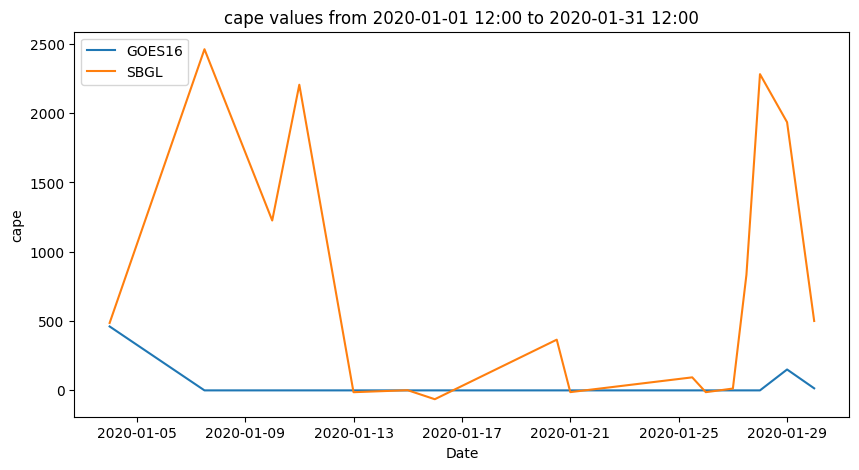

In [84]:

#total_data  = total_data.fillna(0)
#total_data.head(65)
plot_dsif_index_values(total_data, '2020-01-01 12:00','2020-01-31 12:00', 'cape')